<a href="https://colab.research.google.com/github/brooke57/TKR_FLT3_Drug_Discovery/blob/main/Drug_Discovery_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TKR_FLT3 Drug Discovery Modeling**

In [37]:
# Importing Relevant Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import VarianceThreshold

# import xgboost     # extreme gradient boosting


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_cmbd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Model_Dataset.csv')

In [4]:
df_cmbd.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,mol_id,canon_smiles,MolWt,MolLogP,NumHDonors,NumHAcceptors,bioactivity_num,log_std_value
0,CHEMBL124660,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,562.715,5.03450,1,8,1,6.657577
1,CHEMBL330863,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,576.742,5.28050,1,8,1,6.892790
2,CHEMBL126699,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,543.672,4.50748,1,8,0,5.056011
3,CHEMBL445636,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,543.672,4.36498,1,8,0,5.718967
4,CHEMBL124035,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL124035,COCCOc1cc2ncnc(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC...,495.580,3.80490,1,8,1,6.346787


In [5]:
df_cmbd.set_index('Name', inplace=True)

In [6]:
drop = ['mol_id', 'canon_smiles', 'MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'log_std_value', 'log_std_value', 'bioactivity_num']

In [7]:
# Features dataframe
X = df_cmbd.drop(drop, axis=1)
X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHEMBL124660,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHEMBL330863,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHEMBL126699,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHEMBL445636,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHEMBL124035,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
X.shape

(2844, 881)

In [9]:
# Target dataframe
y = df_cmbd['bioactivity_num']

In [10]:
y.shape

(2844,)

### **Train Test Split**

In [11]:
# Setting aside 10% of data for a holdout set to be tested on final model
X_train, X_hold, y_train, y_hold, ind_train, ind_hold = train_test_split(X,y, 
                                                                         X.index,
                                                                         test_size=0.1, random_state=42)

In [12]:
# Train test split for training and testing data
X_tr, X_te, y_tr, y_te, ind_tr, ind_te = train_test_split(X_train, y_train,
                                                          X_train.index,
                                                          test_size=0.2,
                                                          random_state=42)

In [13]:
X_tr.shape

(2047, 881)

In [14]:
y_tr.shape

(2047,)

### **Remove Low Variance Features**

In [15]:
select = VarianceThreshold(threshold = (0.8 * (1 - 0.8)))
select.fit(X_tr)

cols = select.get_support(indices=True)
X_tr = X_tr[X_tr.columns[cols]]
X_te = X_te[X_te.columns[cols]]
X_hold = X_hold[X_hold.columns[cols]]

In [16]:
X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/data/X_features.csv')

In [17]:
# Making sure that X_tr has the same number of rows as y_tr
x_tr_shape = X_tr.shape
y_tr_shape = y_tr.shape
print(f'X_tr shape: {x_tr_shape}')
print(f'y_tr shape: {y_tr_shape}')

X_tr shape: (2047, 149)
y_tr shape: (2047,)


In [18]:
# Making sure that X_te has the same number of rows as y_te
x_te_shape = X_te.shape
y_te_shape = y_te.shape
print(f'X_te shape: {x_te_shape}')
print(f'y_te shape: {y_te_shape}')

X_te shape: (512, 149)
y_te shape: (512,)


In [19]:
# Making sure that X_hold has the same number of rows as y_hold
x_hold_shape = X_hold.shape
y_hold_shape = y_hold.shape
print(f'X_hold shape: {x_hold_shape}')
print(f'y_hold shape: {y_hold_shape}')

X_hold shape: (285, 149)
y_hold shape: (285,)


In [20]:
def evaluate(model, x_train, y_train, x_test, y_test):

  y_train_preds = model.predict(x_train)
  y_test_preds = model.predict(x_test)

  train_acc = str(np.round(accuracy_score(y_train, y_train_preds)*100, 2)) + '%'
  train_pre = str(np.round(precision_score(y_train, y_train_preds)*100, 2)) + '%'
  train_f1 = str(np.round(f1_score(y_train, y_train_preds)*100, 2)) + '%'

  test_acc = str(np.round(accuracy_score(y_test, y_test_preds)*100, 2)) + '%'
  test_pre = str(np.round(precision_score(y_test, y_test_preds)*100, 2)) + '%'
  test_f1 = str(np.round(f1_score(y_test, y_test_preds)*100, 2)) + '%'

  array = [[train_acc, train_pre, train_f1],
           [test_acc, test_pre, test_f1]]

  df = pd.DataFrame(array, columns=['Accuracy', 'Precision', 'F1 Score'])
  df.index = ['Training', 'Testing']

  plot_confusion_matrix(model, x_test, y_test, cmap='plasma', normalize='true')

  return df

## **Decision Tree Classifier**

In [21]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_tr, y_tr)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,98.63%,99.49%,98.83%
Testing,84.77%,87.8%,86.6%


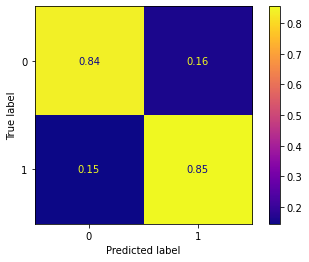

In [22]:
evaluate(dt, X_tr, y_tr, X_te, y_te)

## **Experimenting with Max depth**

In [23]:
# Setting up parameter grid for GridSearchCV
grid = {'max_depth': [5, 10, 15],
        'class_weight': ['balanced', None]
        }

In [24]:
dt2 = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(dt2, grid, scoring = ['f1', 'precision'], refit='f1')

In [25]:
output = search.fit(X_tr, y_tr)

In [27]:
output.best_params_

{'class_weight': 'balanced', 'max_depth': 10}

In [28]:
dtc_best_est = output.best_estimator_
dtc_best_est.fit(X_tr, y_tr)


DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,95.26%,96.78%,95.93%
Testing,85.94%,89.12%,87.59%


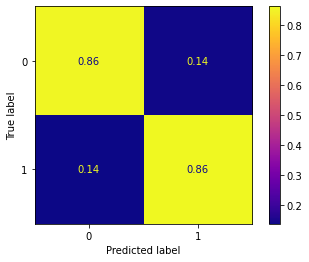

In [29]:
evaluate(dtc_best_est, X_tr, y_tr, X_te, y_te)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


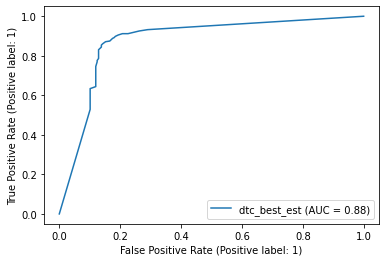

In [30]:
plot_roc_curve(dtc_best_est, X_te, y_te, name='dtc_best_est')

## **Random Forest Classifier**

In [44]:
first_ran = RandomForestClassifier(class_weight='balanced', random_state=42)
first_ran.fit(X_tr, y_tr)

RandomForestClassifier(class_weight='balanced', random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,98.63%,99.0%,98.83%
Testing,90.62%,89.21%,92.13%


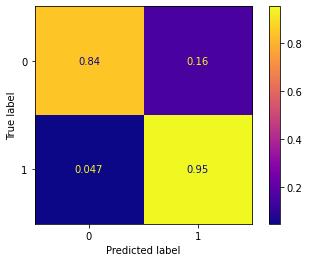

In [33]:
evaluate(first_ran, X_tr, y_tr, X_te, y_te)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


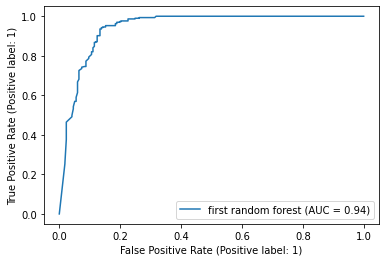

In [34]:
plot_roc_curve(first_ran, X_te, y_te, name='first random forest');

## **Support Vector Machine Model**

In [38]:
first_svm = SVC(class_weight='balanced', random_state=42)
first_svm.fit(X_tr, y_tr)

SVC(class_weight='balanced', random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,91.74%,91.48%,93.09%
Testing,88.67%,86.92%,90.58%


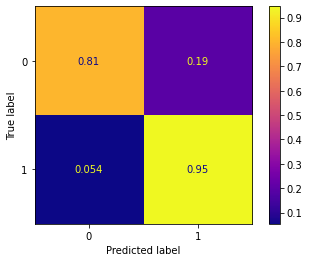

In [39]:
evaluate(first_svm, X_tr, y_tr, X_te, y_te)

In [40]:
gb_grid = {'n_estimators': [100,200],
           'max_depth': [3, 5, 10],
           'learning_rate': [1, 0.1, 0.01]
           }

In [45]:
gb = GradientBoostingClassifier(random_state=42)
gb_search = GridSearchCV(gb, gb_grid, scoring = ['f1', 'precision'], refit='f1')

In [46]:
gb_output = gb_search.fit(X_tr, y_tr)

In [47]:
gb_output.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [48]:
gb_best_est = gb_output.best_estimator_
gb_best_est.fit(X_tr, y_tr)

GradientBoostingClassifier(n_estimators=200, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,94.09%,93.13%,95.07%
Testing,90.04%,88.61%,91.65%


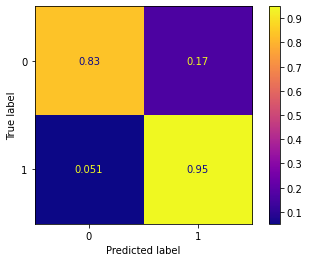

In [49]:
evaluate(gb_best_est, X_tr, y_tr, X_te, y_te)